In [1]:
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from hydra.utils import instantiate

from icicl.utils.experiment_utils import extract_config
from icicl.data.on_off_grid import OOTGBatch, SyntheticOOTGGenerator
from icicl.data.gp import RandomScaleGPGenerator

%load_ext autoreload
%autoreload 2

/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Trying OOTG Batches!

In [2]:
OOTGGen = SyntheticOOTGGenerator(
    off_grid_generator=RandomScaleGPGenerator(
        dim=1, 
        kernel_type= "eq", min_log10_lengthscale= -0.602, max_log10_lengthscale= 0.602, noise_std= 0.2,
        num_tasks=2,
        min_num_ctx = 1, max_num_ctx = 64, min_num_trg = 128, max_num_trg = 128,
        context_range = [[-2.0, 2.0]],
        target_range = [[-3.0, 3.0]],
        samples_per_epoch = 16384,
        batch_size = 16
    ),
    grid_range=[[-3.0, 3.0]],
    points_per_unit=8,
    samples_per_epoch = 16000,
    batch_size = 16,
)

In [3]:
for batch in OOTGGen:
    print(batch.xc_on_grid.shape)
    print(batch.yc_on_grid.shape)
    print(batch.yc_off_grid.shape)
    print(batch.xt.shape)
    break

torch.Size([16, 65, 1])
torch.Size([16, 65, 1])
torch.Size([16, 64, 1])
torch.Size([16, 128, 1])


/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


In [5]:
from icicl.models.ootg_tnp import OOTGSetConvTNPDEncoder
from icicl.utils.helpers import preprocess_observations
from icicl.utils.conv import flatten_grid, unflatten_grid
from icicl.networks.mlp import MLP

dim = 1
xy_encoder = MLP(in_dim= 3 + dim, out_dim = 5, num_layers = 2, width= 32)

grid_encoder = OOTGSetConvTNPDEncoder(dim=dim, init_lengthscale=2 * 1/ 4, xy_encoder = xy_encoder, transformer_encoder=None)

patch_size = 16
conv = torch.nn.Conv1d(in_channels=5, out_channels=5, kernel_size=patch_size, stride=patch_size)

def coarsen_grid(z: torch.Tensor) -> torch.Tensor:
        
        # z will be of shape (batch, num_on_grid, embed_dim)
        z = unflatten_grid(z, dim=dim)
        # move 'channels' (i.e embed_dim) right after batch
        z = z.movedim(-1, 1)
        z = conv(z)
        # move 'channels' (i.e embed_dim) to end again
        z = z.movedim(1, -1)
        return flatten_grid(z)

for batch in OOTGGen:
    xc, yc = grid_encoder.grid_encode(xc_off_grid=batch.xc_off_grid, yc_off_grid=batch.yc_off_grid, xc_on_grid=batch.xc_on_grid, yc_on_grid=batch.yc_on_grid)
    print(yc.shape)
    yc, yt = preprocess_observations(batch.xt, yc)
    print(yc.shape)
    zc = torch.cat((xc, yc), dim=-1)
    print(zc.shape)
    # So zc is 3 + xdim
    zc = xy_encoder(zc)
    print(zc.shape)
    zc = coarsen_grid(zc)  
    print(zc.shape) 

    zt = torch.cat((batch.xt, yt), dim=-1)
    zt = xy_encoder(zt)
    print(zt.shape)
    break

torch.Size([16, 65, 2])
torch.Size([16, 65, 3])
torch.Size([16, 65, 4])
torch.Size([16, 65, 5])
torch.Size([16, 4, 5])
torch.Size([16, 128, 5])


# Profiling

In [21]:
config_tnp, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config_vit, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_vit.yml", [])
pl.seed_everything(config_tnp.misc.seed)
experiment_tnp = instantiate(config_tnp)
experiment_vit = instantiate(config_vit)
pl.seed_everything(experiment_tnp.misc.seed)

Global seed set to 0


Global seed set to 0


0

In [25]:
from icicl.utils.experiment_utils import np_loss_fn
import time

tnp = experiment_tnp.model
vit = experiment_vit.model
gen_train = experiment_tnp.generators.train

start = time.time()
for i, batch in enumerate(gen_train):
    #model.encoder.grid_encode(batch.xc_off_grid, batch.yc_off_grid, batch.xc_on_grid, batch.yc_on_grid)
    np_loss_fn(vit, batch)
    
    if i > 100:
        break

print(f"This took {time.time() - start} seconds")

This took 9.36855959892273 seconds


# ConvSet TNP Encoder Tests

In [20]:
from icicl.utils.conv import make_grid, flatten_grid, unflatten_grid
import torch 
import math
import einops

grid_range = torch.as_tensor([[-3.0, 3.0], [-4.0, 4.0]])
print(grid_range)

batch_shape = torch.Size((2,))


grid = make_grid(
    xmin = grid_range[:, 0].repeat(*batch_shape, 1), 
    xmax = grid_range[:, 1].repeat(*batch_shape, 1), 
    points_per_unit = 4, 
    margin = 0)

print(grid.shape)



plat = flatten_grid(grid)

onplat = unflatten_grid(plat)


torch.allclose(grid, onplat)


tensor([[-3.,  3.],
        [-4.,  4.]])
torch.Size([2, 33, 33, 2])


True

# Getting the true log-likelihood

In [20]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", ["params.ignore_on_grid=False"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["num_tasks"] = 2 # TODO change
config["generators"]["off_grid_generator_val"]["task_correlation"] = 0.5
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)


Global seed set to 0
Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: 100%|██████████| 1/1 [00:00<00:00, 25.19it/s]


In [21]:
print(batches[0].xc.shape, batches[0].yc.shape, batches[0].xt.shape, batches[0].yt.shape)

torch.Size([16, 110, 1]) torch.Size([16, 110, 1]) torch.Size([16, 128, 1]) torch.Size([16, 128, 1])


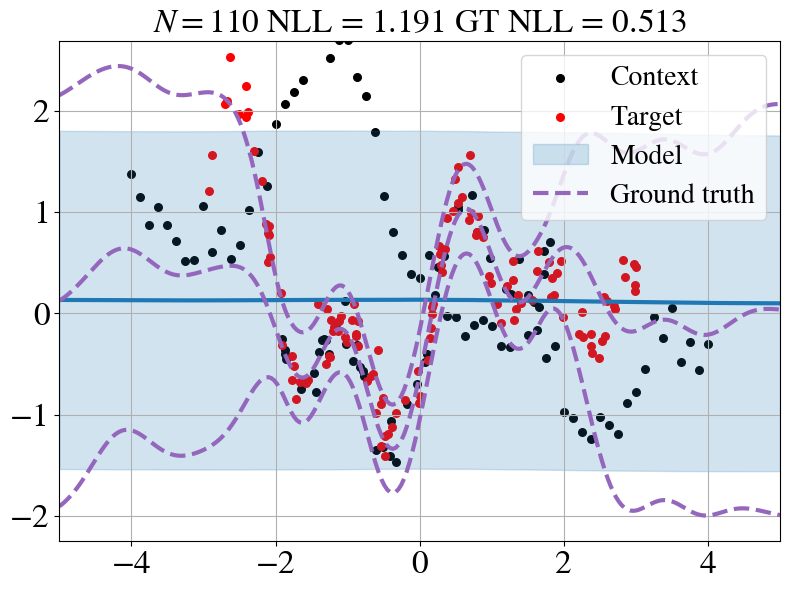

In [22]:
plot(model=experiment.model, batches=batches, num_fig=1)

# Trying attention mask encoder

In [1]:
%load_ext autoreload
%autoreload 2

import torch

from icicl.networks.attention_layers import MultiHeadCrossAttentionLayer
from icicl.networks.transformer import TNPDTransformerEncoder

emb_dim = 5
mhca_layer = MultiHeadCrossAttentionLayer(embed_dim=emb_dim, num_heads=2, head_dim=3, feedforward_dim=emb_dim)

on_grid = torch.randn(2, 4, emb_dim)
off_grid = torch.randn(2, 3, emb_dim)
single = torch.randn(emb_dim)

mhca_layer(on_grid, off_grid).shape

torch.Size([2, 4, 5])

In [2]:
# natively find idx's:
for idx,batch in enumerate(off_grid):
    for vec in batch:
        beste = (on_grid[idx] - vec).abs().sum(dim=-1).argmin()
        print(f"batch{idx}: {beste}")

batch0: 3
batch0: 3
batch0: 2
batch1: 3
batch1: 2
batch1: 0


In [3]:
B, U, E = off_grid.shape # 'U'nstructured
S = on_grid.shape[-2] # 'S'tructured


ap = on_grid.repeat(U,1, 1, 1).movedim(0,1)
bp = off_grid.repeat(S,1, 1, 1).movedim(0,2)

idx = (bp - ap).abs().sum(dim=-1).argmin(dim=2)
print(idx)

batch_idx = torch.arange(B).unsqueeze(-1).repeat(1, U)
u_idx = torch.arange(U).repeat(B, 1)

mask = torch.zeros(B, U, S, dtype=torch.long)
mask[batch_idx, u_idx, idx] = 1
mask

tensor([[3, 3, 2],
        [3, 2, 0]])


tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 1, 0]],

        [[0, 0, 0, 1],
         [0, 0, 1, 0],
         [1, 0, 0, 0]]])

In [4]:
max_patch = mask.sum(dim=1).amax()
print("max_patches", max_patch)

cumcount_idx = (mask.cumsum(dim=1) - 1)[batch_idx, u_idx, idx]
cumcount_idx

max_patches tensor(2)


tensor([[0, 1, 0],
        [0, 0, 0]])

In [5]:
gridded = torch.full((B, S, max_patch + 1, E), -torch.inf)
gridded[batch_idx, idx, cumcount_idx] = off_grid[batch_idx, torch.arange(U)]

batch_idx_s = torch.arange(B).unsqueeze(-1).repeat(1, S)
s_idx = torch.arange(S).repeat(B, 1)
gridded[batch_idx_s, s_idx, -1] = on_grid[batch_idx_s, torch.arange(S)]
gridded

tensor([[[[   -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf],
          [ 1.6908,  0.3320, -0.1903,  0.1614,  0.4556]],

         [[   -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf],
          [ 1.6221, -1.7130, -1.2395, -0.4254,  0.9885]],

         [[ 0.5598, -0.1870,  0.9425,  0.5394, -2.9451],
          [   -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.0676, -0.1920,  1.9067,  0.4510, -1.3878]],

         [[-0.4825,  1.2036,  0.7812, -0.0158,  1.9404],
          [-0.0231, -0.8376, -0.6251,  0.5332,  1.5173],
          [ 0.0741, -0.4089, -0.5627,  0.0466,  1.7228]]],


        [[[-2.3589, -1.5525,  0.0800,  1.5411, -0.0185],
          [   -inf,    -inf,    -inf,    -inf,    -inf],
          [-1.2291, -0.5358, -0.3172,  0.5066,  0.6148]],

         [[   -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.2852,

In [6]:
import einops

gridded_stacked = einops.rearrange(gridded, "b s m e -> (b s) m e")

stacked_mask_idx = gridded_stacked.sum(-1) == -torch.inf

att_mask = torch.ones(B * S, max_patch + 1, S, dtype=torch.bool)
att_mask[stacked_mask_idx, :] = False
att_mask


tensor([[[False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [False, False, False, False],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [False, False, False, False],
         [ True,  True,  True,  True]]])

In [9]:
# necessary to not get loads of nans
gridded_stacked[gridded_stacked == -torch.inf] = 0

In [10]:
latents = torch.randn(S, E)
latents = latents.repeat(gridded_stacked.size(0), 1, 1)
latents.shape

torch.Size([8, 4, 5])

In [14]:
output_mask = mhca_layer(latents, gridded_stacked, mask=att_mask.transpose(-1, -2))
output_no_mask = mhca_layer(latents, gridded_stacked)

print("Mask necessary?", not torch.allclose(output_mask, output_no_mask, equal_nan=True))

print(output_mask.shape)
#output_mask
output = einops.rearrange(output_mask, "(b ignore) s e -> b ignore s e", b=B)
print(output[:, 0].shape)




Mask necessary? True
torch.Size([8, 4, 5])
torch.Size([2, 4, 5])


In [11]:
# https://github.com/pytorch/pytorch/issues/70540

def torch_cumcount(x):
    (nnz_diff, ) = torch.nonzero(torch.diff(x), as_tuple=True)
    marker_idx = nnz_diff + 1
    counts = torch.diff(marker_idx, prepend=torch.zeros(1, dtype=int))
    counter = torch.ones(len(x), dtype=int)
    counter[marker_idx] -= counts
    return counter.cumsum(dim=-1) - 1

print(idx)
torch_cumcount(idx[1])

tensor([[3, 2, 1],
        [2, 0, 0]])


tensor([0, 0, 1])